In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
import sunradiation as sun
import weatherfeed as wf

# Modèle 02

Calcul de l'équilibre thermique des tuiles du toit, prennant en compte :
    - Le rayonement solaire sur le toit
    - Le rayonement propres des tuiles (corps noir)
    - La convection avec l'air extérieur (forcée par le vent, ou bien naturelle)
    

## Get the data

### Météo

In [3]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('24/06/2017'), pd.to_datetime('now')

In [4]:
data = wf.buildmultidayDF(startday, lastday, coords_grenoble )

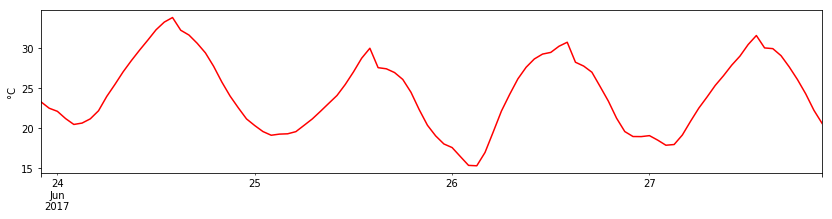

In [5]:
data['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

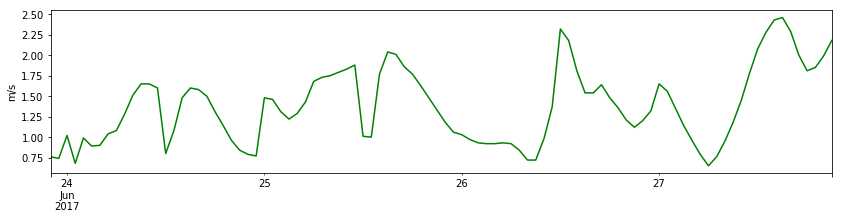

In [6]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s');

### Irradiation solaire

In [7]:
def buildfluxdataframe(dateindex, cloudCover, coords, sigma, phi_C):
    df = [ sun.get_flux_surface( coords, d, sigma, phi_C ) \
                 for d in dateindex ]*( 1 - cloudCover )
    
    return df

In [8]:
sigma = 37  # deg, angle du toit coté bastille
phi_C_bastille = 50  # deg, azimuth du toit
phi_C_vercors = 50+180  # deg, azimuth du toit


data['Flux_bastille'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_bastille)


data['Flux_vercors'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_vercors)


/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


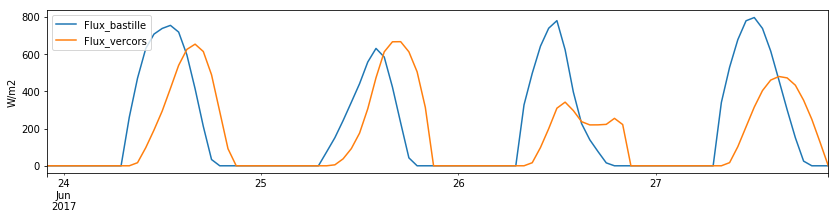

In [9]:
data[['Flux_bastille', 'Flux_vercors']].plot(figsize=(14, 3) )
plt.ylabel('W/m2');

## Grandeurs physiques

In [10]:
def coef_echange( vitesse_vent ):
    # vitesse_vent: m/s
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Prandl
    
    L = 4 # m, taille caractéristique, toit ou tuile ?
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 5e3:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
    
    return h

In [11]:
coef_echange( 2 )

7.732272559314057

In [12]:
albedo_tuile = 0.36  # Coef de reflexion tuiles

## Modèle SANS rayonement

In [13]:
# Coefficient d'échange pour la convection: 
h = data['windSpeed'].apply(coef_echange)

In [14]:
# Modèle :
Ttuile = {}
Ttuile['bastille'] = data['temperature'] + (1-albedo_tuile)*data['Flux_bastille']/h
Ttuile['vercors'] = data['temperature']  + (1-albedo_tuile)*data['Flux_vercors']/h


Ttuile = pd.DataFrame(Ttuile)

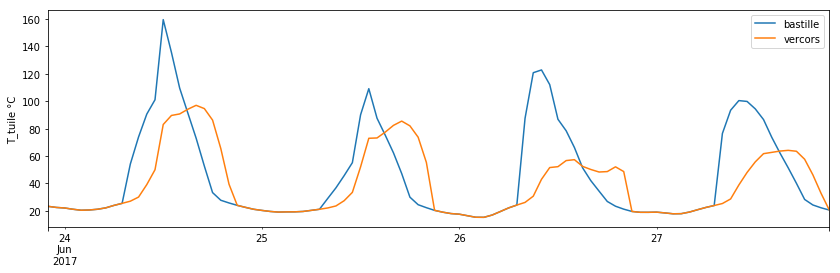

In [15]:
Ttuile.plot(figsize=(14, 4) ); plt.ylabel('T_tuile °C');

## Modèle avec le rayonement du toit

In [16]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [17]:
from scipy.optimize import brentq

In [42]:
def model02_apply( datarow, colflux=None, disp=False  ):
    flux_soleil = datarow[ colflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )
    
    emissivite_tuile = 0.92

    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    convection = lambda T: -h * (T - T_air)
    rayonement_toit = lambda T: -sigmaSB*emissivite_tuile*( T + 273 )**4
    #rayonement_ciel =  +sigmaSB*( T_air + 273 )**4  # insert cloud cover here
    rayonement_ciel = Goforth_skyrad( datarow )
    
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    if disp:
        print( convection(T_eq), rayonement_toit(T_eq), rayonement_soleil, rayonement_ciel )
    
    return T_eq

In [54]:
def Goforth_skyrad( datarow ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    C = datarow['cloudCover']
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = datarow['temperature'] + 273
    RH = datarow['humidity']

    Pthermal = ( 1 + K*C**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal

In [55]:
Ttuile = {}
Ttuile['bastille'] = data.apply(model02_apply, axis=1, colflux='Flux_bastille')
Ttuile['vercors'] = data.apply(model02_apply, axis=1, colflux='Flux_vercors')

Ttuile = pd.DataFrame(Ttuile)

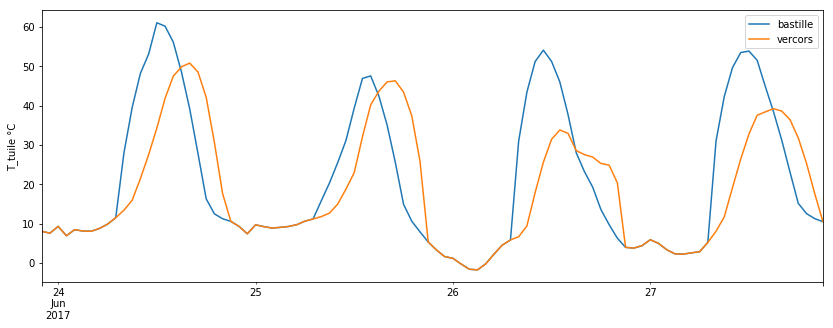

In [56]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

In [62]:
# Pour voir la repartition :
row = data.to_dict(orient='index')[pd.to_datetime( '26/06/2017 01h00' ) ]
model02_apply( row, colflux='Flux_bastille' , disp=True )

72.6118306577 -288.5657587864519 0.0 215.953928129


-0.2835497998484142

In [52]:
# Zoom
zoom_start = pd.to_datetime( '27/06/2017' ) 
mask = (data.index > zoom_start)

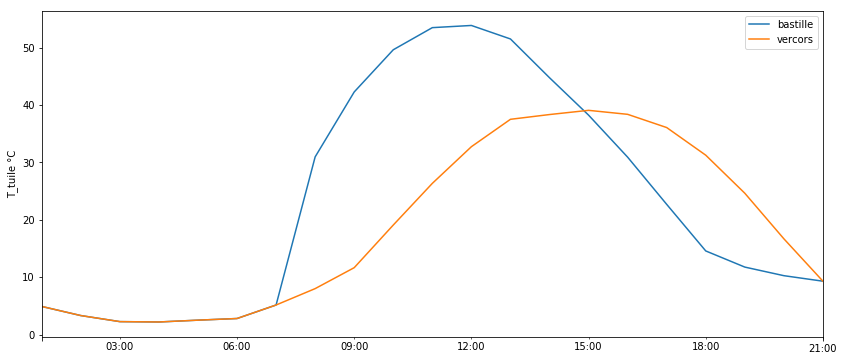

In [53]:
Ttuile.loc[mask].plot(figsize=(14, 6) ); plt.ylabel('T_tuile °C');

### Remarques
- 'true' temperature du ciel
- Radiation diffuse ? same as sky temp ?
- Prise en compte de la pluie ... ?
- Effet des velux ?
- Pour le mur vertical ? 

- La nuit Ttuile < T_air ... ? condensation ? convection inversée...